In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import gc

np.random.seed(42)
import sys
sys.path.insert(0, '../scripts/')

## Import LHCO 2020 dataset

The dataset is available here: https://zenodo.org/record/4536377#.YZgz2L3ML0o

* It consists of 1M QCD dijet events, 100k W'->XY (2-prong) events, with X->qq and Y->qq and 100k W'->XY (3-prong) events, with X->qqq and Y->qqq. The events are randomly shuffled together.
* A signal/background truth label for each event is provided to identify the signal and background events.
* The W', X, and Y masses are 3.5 TeV, 500 GeV and 100 GeV respectively.

In [2]:
# R&D Dataset for LHC Olympics 2020 Anomaly Detection Challenge
# https://zenodo.org/record/4536377#.YZgz2L3ML0o

# Original R&D dataset: Pythia QCD + W' signal (2-prong)
pythia_raw = pd.read_hdf("/home/elham/anomaly_detection/anomaly-detection/data/events_anomalydetection_v2.features.h5")

# Original R&D dataset: W' signal (3-prong)
signal_3prong_raw = pd.read_hdf("/home/elham/anomaly_detection/anomaly-detection/data/events_anomalydetection_Z_XY_qqq.features.h5")

# Extra R&D dataset (SR): Pythia QCD 
pythia_extra1_raw = pd.read_hdf("/home/elham/anomaly_detection/anomaly-detection/data/events_anomalydetection_DelphesPythia8_v2_qcd_extra_inneronly_features.h5")
pythia_extra2_raw = pd.read_hdf("/home/elham/anomaly_detection/anomaly-detection/data/events_anomalydetection_DelphesPythia8_v2_qcd_extra_inneronly_batch2_features.h5")


In [3]:
print ("====== Background Shape ======")
print ("LHCO R&D bkg + signal shape: ", pythia_raw.shape)
print ("")
print ("====== Background Shape ======")
print ("Extra (batch 1) bkg shape: ", pythia_extra1_raw.shape)
print ("Extra (batch 2) bkg shape: ", pythia_extra2_raw.shape)
print ("")
print ("====== Signal Shape ======")
print ("LHCO R&D signal (3-prong) shape: ", signal_3prong_raw.shape)

====== Background Shape ======
LHCO R&D bkg + signal shape:  (1100000, 15)

====== Background Shape ======
Extra (batch 1) bkg shape:  (312858, 14)
Extra (batch 2) bkg shape:  (300000, 14)

====== Signal Shape ======
LHCO R&D signal (3-prong) shape:  (100000, 14)


## Define Signal Region (SR) and SideBand Region (SB)

In [4]:
# SB definition: mjj = [2.5, 3.3] U [3.7,10.0] TeV
low_sb = 2500
high_sb = 10000

# SR definition: mjj = [3.3, 3.7] TeV
low_sr = 3300
high_sr = 3700

# Load data
## QCD background, 2-prong and 3-prong W' signal
High level features ae used for this study.


In [5]:
def load_data(input_frame):
    
    '''
    Input: initial data-frame 
    Return: another data-frame with some extra variables
    '''
    
    # copy the input_dataframe
    output_frame = input_frame.copy()

    gc.collect()
    # Add more variables computed using the initial variables
    # toal momentum
    output_frame["pj1"] = np.sqrt(output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["pj2"] = np.sqrt(output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    # transverse momentum
    output_frame["ptj1"] = np.sqrt(output_frame["pxj1"]**2 + output_frame["pyj1"]**2) # in GeV!
    output_frame["ptj2"] = np.sqrt(output_frame["pxj2"]**2 + output_frame["pyj2"]**2) # in GeV!
    # energy
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pj2"]**2)
    # dijet system
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pzj1"] + output_frame["pzj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    # n-subjettiness ratios
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    # eta
    output_frame["etaj1"] = np.arctanh(output_frame["pzj1"]/output_frame["pj1"])
    output_frame["etaj2"] = np.arctanh(output_frame["pzj2"]/output_frame["pj2"])
    # phi
    output_frame["phij1"] = np.arctan2(output_frame["pyj1"],output_frame["pxj1"])
    output_frame["phij2"] = np.arctan2(output_frame["pyj2"],output_frame["pxj2"])
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)
    return output_frame.astype('float32')

In [6]:
df_sig_3prong_total = load_data(signal_3prong_raw)
df_comb = load_data(pythia_raw)
df_bkg_extra1 = load_data(pythia_extra1_raw)
df_bkg_extra2 = load_data(pythia_extra2_raw)

In [7]:
df_bkg = df_comb.loc[df_comb['label'] == 0]
df_bkg.reset_index(drop = True, inplace = True)
df_sig_2prong_total = df_comb.loc[df_comb['label'] == 1]
df_sig_2prong_total.reset_index(drop = True, inplace = True)

# Split 3-prong signal events into synthetic data and the rest used for training,validation,testing
df_sig_2prong_data = df_sig_2prong_total[:1000]
df_sig_2prong = df_sig_2prong_total[1000:]
df_sig_2prong.reset_index(drop = True, inplace = True)

# Split 3-prong signal events into synthetic data and the rest used for training,validation,testing
df_sig_3prong_data = df_sig_3prong_total[:1000]
df_sig_3prong = df_sig_3prong_total[1000:]
df_sig_3prong.reset_index(drop = True, inplace = True)

In [8]:
print ("====== Background Shape ======")
print ("LHCO R&D bkg shape: ", df_bkg.shape)
print ("Extra (batch 1) bkg shape: ", df_bkg_extra1.shape)
print ("Extra (batch 2) bkg shape: ", df_bkg_extra2.shape)
print ("")
print ("====== Signal Shape ======")
print ("LHCO R&D signal (2-prong) shape: ", df_sig_2prong.shape)
print ("LHCO R&D signal (3-prong) shape: ", df_sig_3prong.shape)
print ("")
print ("====== Signal Shape (part of the synthetic data) ======")
print ("Synthetic data signal (2-prong) shape: ", df_sig_2prong_data.shape)
print ("Synthetic data signal (3-prong) shape: ", df_sig_3prong_data.shape)


====== Background Shape ======
LHCO R&D bkg shape:  (999881, 32)
Extra (batch 1) bkg shape:  (312823, 31)
Extra (batch 2) bkg shape:  (299968, 31)

====== Signal Shape ======
LHCO R&D signal (2-prong) shape:  (98966, 32)
LHCO R&D signal (3-prong) shape:  (98969, 31)

====== Signal Shape (part of the synthetic data) ======
Synthetic data signal (2-prong) shape:  (1000, 32)
Synthetic data signal (3-prong) shape:  (1000, 31)


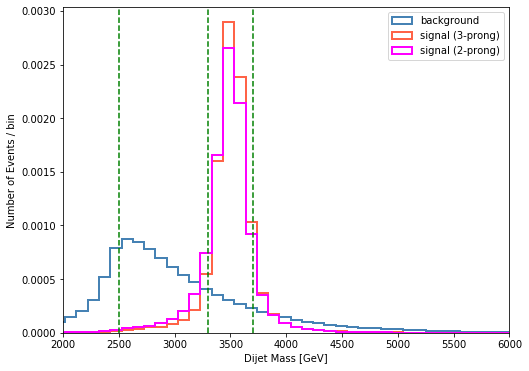

In [9]:
plt.figure(figsize=(8,6))
plt.xlim(2000,6000)
plt.hist(df_bkg["mjj"], np.linspace(0,10000,100), color="steelblue", histtype='step', linewidth=2, label="background",density=True)
plt.hist(df_sig_3prong["mjj"], np.linspace(0,10000,100), color="tomato", histtype='step', linewidth=2, label="signal (3-prong)",density=True)
plt.hist(df_sig_2prong["mjj"], np.linspace(0,10000,100), color="magenta", histtype='step', linewidth=2, label="signal (2-prong)",density=True)
plt.xlabel("Dijet Mass [GeV]")
plt.axvline(low_sb, color="green",ls='--')
plt.axvline(low_sr, color="green",ls='--')
plt.axvline(high_sb, color="green",ls='--')
plt.axvline(high_sr, color="green", ls='--')
# plt.yscale('log')
plt.ylabel("Number of Events / bin")
plt.legend(loc="upper right")

# Split dataset into SR and SB

In [10]:
# Define sidebands and sig_2prongnal region
df_bkg_SB = df_bkg[((df_bkg["mjj"] > low_sb) & (df_bkg["mjj"] < low_sr)) | ((df_bkg["mjj"] > high_sr) & (df_bkg["mjj"] < high_sb))]
df_bkg_SR = df_bkg[(df_bkg["mjj"] >= low_sr) & (df_bkg["mjj"] <= high_sr)]

df_sig_2prong_SB = df_sig_2prong[((df_sig_2prong["mjj"] > low_sb) & (df_sig_2prong["mjj"] < low_sr)) | ((df_sig_2prong["mjj"] > high_sr) & (df_sig_2prong["mjj"] < high_sb))]
df_sig_2prong_SR = df_sig_2prong[(df_sig_2prong["mjj"] >= low_sr) & (df_sig_2prong["mjj"] <= high_sr)]

df_sig_3prong_SB = df_sig_3prong[((df_sig_3prong["mjj"] > low_sb) & (df_sig_3prong["mjj"] < low_sr)) | ((df_sig_3prong["mjj"] > high_sr) & (df_sig_3prong["mjj"] < high_sb))]
df_sig_3prong_SR = df_sig_3prong[(df_sig_3prong["mjj"] >= low_sr) & (df_sig_3prong["mjj"] <= high_sr)]

df_sig_2prong_SB_data = df_sig_2prong_data[((df_sig_2prong_data["mjj"] > low_sb) & (df_sig_2prong_data["mjj"] < low_sr)) | ((df_sig_2prong_data["mjj"] > high_sr) & (df_sig_2prong_data["mjj"] < high_sb))]
df_sig_2prong_SR_data = df_sig_2prong_data[(df_sig_2prong_data["mjj"] >= low_sr) & (df_sig_2prong_data["mjj"] <= high_sr)]

df_sig_3prong_SB_data = df_sig_3prong_data[((df_sig_3prong_data["mjj"] > low_sb) & (df_sig_3prong_data["mjj"] < low_sr)) | ((df_sig_3prong_data["mjj"] > high_sr) & (df_sig_3prong_data["mjj"] < high_sb))]
df_sig_3prong_SR_data = df_sig_3prong_data[(df_sig_3prong_data["mjj"] >= low_sr) & (df_sig_3prong_data["mjj"] <= high_sr)]

for df in [df_bkg_SB, df_bkg_SR, df_sig_2prong_SB, df_sig_2prong_SR, df_sig_3prong_SB, df_sig_3prong_SR, df_sig_2prong_SB_data, df_sig_2prong_SR_data, df_sig_3prong_SB_data, df_sig_3prong_SR_data]:
    df.reset_index(drop = True, inplace = True)

In [11]:

print("Size of uncut data:")
print("")
print("df_bg shape {}".format(df_bkg.shape))
print("df_sig (2-prong) shape {}".format(df_sig_2prong.shape))
print("df_sig (3-prong) shape {}".format(df_sig_3prong.shape))
print("df_bg_SB shape {}".format(df_bkg_SB.shape))
print("df_sig_SB (2-prong) shape {}".format(df_sig_2prong_SB.shape))
print("df_sig_SB (3-prong) shape {}".format(df_sig_3prong_SB.shape))
print("df_sig_SB_data (2-prong) shape {}".format(df_sig_2prong_SB_data.shape))
print("df_sig_SB_data (3-prong) shape {}".format(df_sig_3prong_SB_data.shape))
print("df_bg_SR shape {}".format(df_bkg_SR.shape))
print("df_bg_extra1 (batch 1) shape {}".format(df_bkg_extra1.shape))
print("df_bg_extra2 (batch 2) shape {}".format(df_bkg_extra2.shape))
print("df_sig_SR (2-prong) shape {}".format(df_sig_2prong_SR.shape))
print("df_sig_SR (3-prong) shape {}".format(df_sig_3prong_SR.shape))
print("df_sig_SR_data (2-prong) shape {}".format(df_sig_2prong_SR_data.shape))
print("df_sig_SR_data (3-prong) shape {}".format(df_sig_3prong_SR_data.shape))
print()

Size of uncut data:

df_bg shape (999881, 32)
df_sig (2-prong) shape (98966, 32)
df_sig (3-prong) shape (98969, 31)
df_bg_SB shape (680992, 32)
df_sig_SB (2-prong) shape (23883, 32)
df_sig_SB (3-prong) shape (19687, 31)
df_sig_SB_data (2-prong) shape (218, 32)
df_sig_SB_data (3-prong) shape (208, 31)
df_bg_SR shape (121339, 32)
df_bg_extra1 (batch 1) shape (312823, 31)
df_bg_extra2 (batch 2) shape (299968, 31)
df_sig_SR (2-prong) shape (74527, 32)
df_sig_SR (3-prong) shape (78991, 31)
df_sig_SR_data (2-prong) shape (772, 32)
df_sig_SR_data (3-prong) shape (790, 31)



# Check:  $\geq 1$ jet with $p_T \geq 1.2$ TeV and $|\eta| < 2.5$ 

In [12]:
def cut_data(uncut_data, pTmin = 1199, etamax = 2.5):

    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
#     return uncut_data[(uncut_data[:,all_features.index("ptj1")] > pTmin) | (uncut_data[:,all_features.index("ptj2")] > pTmin)]
    return uncut_data[((uncut_data[:,all_features.index("ptj1")] > pTmin) & (np.abs(uncut_data[:,all_features.index("etaj1")]) < etamax)) | ((uncut_data[:,all_features.index("ptj2")] > pTmin) & (np.abs(uncut_data[:,all_features.index("etaj2")]) < etamax))]



In [13]:
def cut_dataframe(uncut_data, pTmin = 1199, etamax = 2.5):

    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
#     return uncut_data[(uncut_data[:,all_features.index("ptj1")] > pTmin) | (uncut_data[:,all_features.index("ptj2")] > pTmin)]
    outdata = uncut_data[((uncut_data["ptj1"] > pTmin) & (np.abs(uncut_data["etaj1"]) < etamax)) | ((uncut_data["ptj2"] > pTmin) & (np.abs(uncut_data["etaj2"]) < etamax))]
    outdata.reset_index(drop = True, inplace = True)
    return outdata



In [14]:
out_features = ["ptj1", "etaj1", "phij1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2", "tau32j1", "tau32j2"]
condition_features = ["mjj"]
all_features = out_features + condition_features

In [15]:
all_bkg_SB = cut_dataframe(df_bkg_SB[all_features])
all_bkg_SR = cut_dataframe(df_bkg_SR[all_features])
all_bkg_SR_extra1 = cut_dataframe(df_bkg_extra1[all_features])
all_bkg_SR_extra2 = cut_dataframe(df_bkg_extra2[all_features])
all_sig_2prong_SB = cut_dataframe(df_sig_2prong_SB[all_features])
all_sig_2prong_SR = cut_dataframe(df_sig_2prong_SR[all_features])
all_sig_3prong_SB = cut_dataframe(df_sig_3prong_SB[all_features])
all_sig_3prong_SR = cut_dataframe(df_sig_3prong_SR[all_features])

all_sig_2prong_SB_data = cut_dataframe(df_sig_2prong_SB_data[all_features])
all_sig_2prong_SR_data = cut_dataframe(df_sig_2prong_SR_data[all_features])
all_sig_3prong_SB_data = cut_dataframe(df_sig_3prong_SB_data[all_features])
all_sig_3prong_SR_data = cut_dataframe(df_sig_3prong_SR_data[all_features])

In [16]:

print("Size of data after cut:")
print("")
print("all_bkg_SB shape {}".format(all_bkg_SB.shape))
print("all_sig_2prong_SB (2-prong) shape {}".format(all_sig_2prong_SB.shape))
print("all_sig_3prong_SB (3-prong) shape {}".format(all_sig_3prong_SB.shape))
print("all_bkg_SR shape {}".format(all_bkg_SR.shape))
print("all_bkg_SR_extra1 shape {}".format(all_bkg_SR_extra1.shape))
print("all_bkg_SR_extra2 shape {}".format(all_bkg_SR_extra2.shape))
print("all_sig_2prong_SR (2-prong) shape {}".format(all_sig_2prong_SR.shape))
print("all_sig_3prong_SR (3-prong) shape {}".format(all_sig_3prong_SR.shape))
print("all_sig_2prong_SR_data (2-prong) shape {}".format(all_sig_2prong_SR_data.shape))
print("all_sig_3prong_SR_data (3-prong) shape {}".format(all_sig_3prong_SR_data.shape))
print()

Size of data after cut:

all_bkg_SB shape (680992, 13)
all_sig_2prong_SB (2-prong) shape (23883, 13)
all_sig_3prong_SB (3-prong) shape (19687, 13)
all_bkg_SR shape (121339, 13)
all_bkg_SR_extra1 shape (312823, 13)
all_bkg_SR_extra2 shape (299968, 13)
all_sig_2prong_SR (2-prong) shape (74527, 13)
all_sig_3prong_SR (3-prong) shape (78991, 13)
all_sig_2prong_SR_data (2-prong) shape (772, 13)
all_sig_3prong_SR_data (3-prong) shape (790, 13)



# SR dataset for Fully Supervised Training (FST) and Common Evaluation

In [17]:
shape_FST = 272500
all_bkg_SR_FST  = all_bkg_SR_extra2[:shape_FST]
all_bkg_SR_test = pd.concat([all_bkg_SR_extra1, all_bkg_SR_extra2[shape_FST:]])
print("Fully Supervised Training background sample shape {}".format(all_bkg_SR_FST.shape))
print("Test background sample shape {}".format(all_bkg_SR_test.shape))

Fully Supervised Training background sample shape (272500, 13)
Test background sample shape (340291, 13)


In [20]:
all_sig_2prong_SR = shuffle(all_sig_2prong_SR)
all_sig_3prong_SR = shuffle(all_sig_3prong_SR)

In [21]:
all_sig_2prong_SR_FST = all_sig_2prong_SR[:54500]
all_sig_3prong_SR_FST = all_sig_3prong_SR[:54500]
print("Fully Supervised Training signal (2-prong) sample shape {}".format(all_sig_2prong_SR_FST.shape))
print("Fully Supervised Training signal (3-prong) sample shape {}".format(all_sig_3prong_SR_FST.shape))

Fully Supervised Training signal (2-prong) sample shape (54500, 13)
Fully Supervised Training signal (3-prong) sample shape (54500, 13)


In [22]:
all_sig_2prong_SR_test = all_sig_2prong_SR[54500:]
all_sig_3prong_SR_test = all_sig_3prong_SR[54500:]
print("Test signal (2-prong) sample shape {}".format(all_sig_2prong_SR_test.shape))
print("Test signal (3-prong) sample shape {}".format(all_sig_3prong_SR_test.shape))

Test signal (2-prong) sample shape (20027, 13)
Test signal (3-prong) sample shape (24491, 13)


# Save the dataset as h5 file

In [23]:
outpath = "/home/elham/anomaly_detection/data/cGAN_dataset/"

# QCD dataset used as background (SR, SB)
all_bkg_SB.to_hdf(outpath+'bkg_SB_train.h5', key='df', mode='w')
all_bkg_SR_FST.to_hdf(outpath+'bkg_SR_FST.h5', key='df', mode='w')
all_bkg_SR_test.to_hdf(outpath+'bkg_SR_test.h5', key='df', mode='w')


# Signal (2 & 3-prong) dataset (SR, SB)
all_sig_2prong_SB.to_hdf(outpath+'sig_2prong_SB.h5', key='df', mode='w')
all_sig_3prong_SB.to_hdf(outpath+'sig_3prong_SB.h5', key='df', mode='w')
all_sig_2prong_SR_FST.to_hdf(outpath+'sig_2prong_SR_FST.h5', key='df', mode='w')
all_sig_3prong_SR_FST.to_hdf(outpath+'sig_3prong_SR_FST.h5', key='df', mode='w')
all_sig_2prong_SR_test.to_hdf(outpath+'sig_2prong_SR_test.h5', key='df', mode='w')
all_sig_3prong_SR_test.to_hdf(outpath+'sig_3prong_SR_test.h5', key='df', mode='w')


# QCD and signal events used as synthetic data (121k QCD + 700 W') in the SR
all_bkg_SR.to_hdf(outpath+'synthdata_QCD_SR.h5', key='df', mode='w')
all_sig_2prong_SR_data.to_hdf(outpath+'synthdata_2prong_sig_SR.h5', key='df', mode='w')
all_sig_3prong_SR_data.to_hdf(outpath+'synthdata_3prong_sig_SR.h5', key='df', mode='w')
